         ┌───┐           ┌───┐  ┌───┐          ┌───┐┌───┐      ░ ┌─┐         »
    q_0: ┤ H ├─■─────────┤ H ├──┤ X ├───────■──┤ X ├┤ H ├──────░─┤M├─────────»
         ├───┤ │         ├───┤  ├───┤       │  ├───┤├───┤      ░ └╥┘┌─┐      »
    q_1: ┤ H ├─■─────────┤ H ├──┤ X ├───────■──┤ X ├┤ H ├──────░──╫─┤M├──────»
         ├───┤ │         ├───┤  ├───┤       │  ├───┤├───┤      ░  ║ └╥┘┌─┐   »
    q_2: ┤ H ├─■─────────┤ H ├──┤ X ├───────■──┤ X ├┤ H ├──────░──╫──╫─┤M├───»
         ├───┤ │         ├───┤  ├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ░  ║  ║ └╥┘┌─┐»
    q_3: ┤ H ├─■─────────┤ H ├──┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─░──╫──╫──╫─┤M├»
         ├───┤ │       ┌─┴───┴─┐└───┘└───┘└───┘└───┘└───┘└───┘ ░  ║  ║  ║ └╥┘»
    q_4: ┤ H ├─┼───────┤0      ├───────────────────────────────░──╫──╫──╫──╫─»
         ├───┤ │       │       │                               ░  ║  ║  ║  ║ »
    q_5: ┤ H ├─┼───────┤1 IQFT ├───────────────────────────────░──╫──╫──╫──╫─»
         ├───┤ │P(π/8) │       │                    

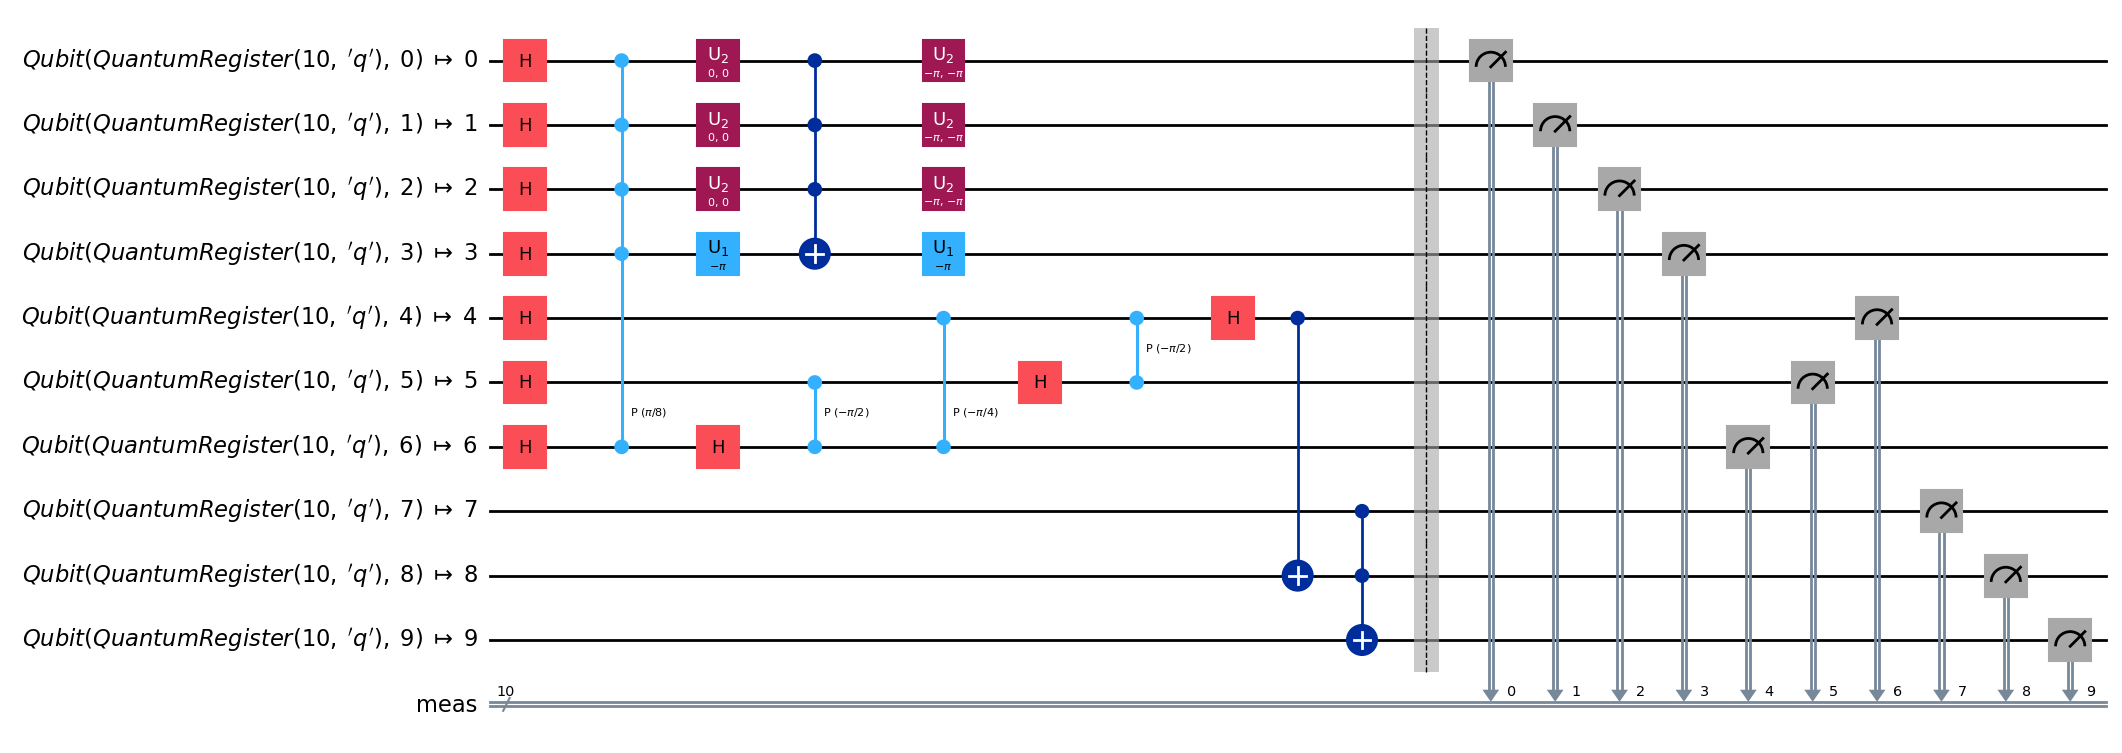

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram, circuit_drawer
import numpy as np

def initialize_superposition(qc, qubits):
    qc.h(qubits)

def controlled_U(qc, control_qubits, target_qubit):
    qc.mcp(2 * np.pi / (2 ** len(control_qubits)), control_qubits, target_qubit)

def quantum_comparator(qc, cost_qubits, threshold_qubit, ancilla):
    qc.cx(cost_qubits[-1], threshold_qubit)

def diffusion_operator(qc, qubits):
    qc.h(qubits)
    qc.x(qubits)
    qc.h(qubits[-1])
    qc.mcx(qubits[:-1], qubits[-1])
    qc.h(qubits[-1])
    qc.x(qubits)
    qc.h(qubits)

def grover_adaptive_search(mN, t):
    num_qubits = mN + t + 3  # Includes RCL, RHCD, and R
    qc = QuantumCircuit(num_qubits)
    
    C_qubits = list(range(mN))
    T_qubits = list(range(mN, mN + t))
    RCL_qubit = mN + t
    RHCD_qubit = mN + t + 1
    R_qubit = mN + t + 2
    
    initialize_superposition(qc, C_qubits + T_qubits)
    
    Iopt = int(np.ceil(np.sqrt(2 ** mN) / 4))
    
    for _ in range(Iopt):
        controlled_U(qc, C_qubits, T_qubits[-1])
        qc.append(QFT(t, inverse=True), T_qubits)
        quantum_comparator(qc, T_qubits, RHCD_qubit, RCL_qubit)
        qc.ccx(RHCD_qubit, RCL_qubit, R_qubit)  # Toffoli gate for marking valid solutions
        qc.x(R_qubit)
        diffusion_operator(qc, C_qubits)
        qc.x(R_qubit)
    
    qc.measure_all()
    
    print(qc.draw(output='text'))  # Draw and print the circuit
    
    backend = Aer.get_backend('qasm_simulator')
    transpiled_qc = transpile(qc, backend)
    
    return transpiled_qc

mN = 4  # Example number of cycle qubits
t = 3   # Example number of cost qubits
transpiled_qc = grover_adaptive_search(mN, t)
circuit_drawer(transpiled_qc, output='mpl')
